<a href="https://colab.research.google.com/github/e-vdb/comment-emotion-analysis/blob/main/NLP_emotionAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"emelinevanderbeken","key":"fdef7825bb20ad21c25fc469ea16f6fd"}'}

In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
!  kaggle datasets download -d praveengovi/emotions-dataset-for-nlp

  0% 0.00/721k [00:00<?, ?B/s]
100% 721k/721k [00:00<00:00, 48.4MB/s]


In [7]:
! mkdir data

In [8]:
! unzip emotions-dataset-for-nlp.zip

Archive:  emotions-dataset-for-nlp.zip
  inflating: test.txt                
  inflating: train.txt               
  inflating: val.txt                 


# Imports

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import OrdinalEncoder
import warnings
warnings.filterwarnings("ignore")

# Exploratory data analysis

In [11]:
def convert_dataframe(filename):
  with open(filename) as f:
    data = f.read()
  data_split = [row.split(';') for row in data.split('\n')]
  df = pd.DataFrame(data=data_split, columns=['comment', 'emotion'])
  return df

In [12]:
data_train = convert_dataframe('train.txt')
data_train

,comment,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
15996,i am now turning and i feel pathetic that i am...,sadness
15997,i feel strong and good overall,joy
15998,i feel like this was such a rude comment and i...,anger
15999,i know a lot but i feel so stupid because i ca...,sadness


In [13]:
data_val = convert_dataframe('val.txt')
data_val

,comment,emotion
0,im feeling quite sad and sorry for myself but ...,sadness
1,i feel like i am still looking at a blank canv...,sadness
2,i feel like a faithful servant,love
3,i am just feeling cranky and blue,anger
4,i can have for a treat or if i am feeling festive,joy
...,...,...
1996,i constantly worry about their fight against n...,joy
1997,i feel its important to share this info for th...,joy
1998,i truly feel that if you are passionate enough...,joy
1999,i feel like i just wanna buy any cute make up ...,joy


In [14]:
data_test = convert_dataframe('test.txt')
data_test

,comment,emotion
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness
...,...,...
1996,im feeling a little cranky negative after this...,anger
1997,i feel that i am useful to my people and that ...,joy
1998,im feeling more comfortable with derby i feel ...,joy
1999,i feel all weird when i have to meet w people ...,fear


In [15]:
def emotion_representation(data):
  print(data.emotion.value_counts())
  plt.figure(figsize=(12,6))
  sns.catplot(x='emotion', kind='count', data=data)
  plt.title('Graphic representation of sentiment')
  plt.show()

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: emotion, dtype: int64


<Figure size 864x432 with 0 Axes>

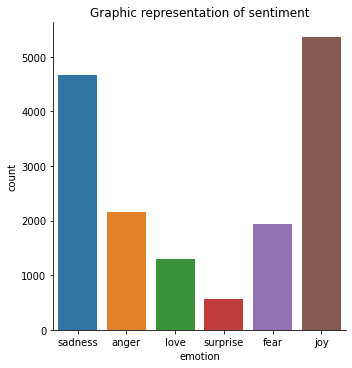

joy         704
sadness     550
anger       275
fear        212
love        178
surprise     81
Name: emotion, dtype: int64


<Figure size 864x432 with 0 Axes>

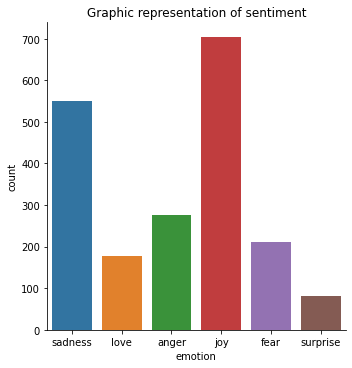

joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: emotion, dtype: int64


<Figure size 864x432 with 0 Axes>

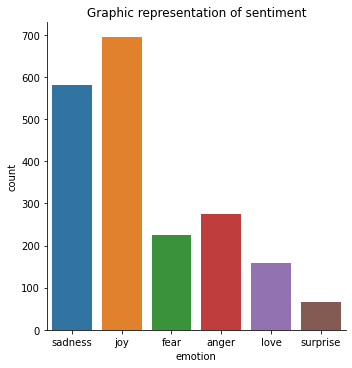

In [16]:
dataset = [data_train, data_val, data_test]
for data in dataset:
  emotion_representation(data)

# Data preprocessing

## Ordinal encoding

In [17]:
train_label = np.array(data_train.emotion).reshape(-1,1)
val_label = np.array(data_val.emotion).reshape(-1,1)
test_label = np.array(data_test.emotion).reshape(-1,1)

enc = OrdinalEncoder()
y_train = enc.fit_transform(train_label.astype(str)).ravel()
y_val =  enc.transform(val_label.astype(str)).ravel()
y_test =  enc.transform(test_label.astype(str)).ravel()

In [18]:
y_train

array([5., 5., 1., ..., 1., 5., 0.])

In [19]:
enc.categories_

[array(['None', 'anger', 'fear', 'joy', 'love', 'sadness', 'surprise'],
       dtype='<U8')]

In [20]:
enc.inverse_transform(y_val.reshape(-1,1))

array([['sadness'],
       ['sadness'],
       ['love'],
       ...,
       ['joy'],
       ['joy'],
       ['None']], dtype='<U8')

In [21]:
categories = np.array(['None', 'anger', 'fear', 'joy', 'love', 'sadness', 'surprise'])

# ML models

In [22]:
def evaluate_model(model, X_train, y_train, X_val, y_val):
  model.fit(X_train,y_train)
  y_pred = model.predict(X_val)
  confusion = confusion_matrix(y_val, y_pred)
  print(f"Accuracy score on training set {model.score(X_train,y_train)}")
  print(f"Accuracy score on validation set {model.score(X_val,y_val)}")
  print(f"Confusion matrix\n {confusion}")
  print(classification_report(y_val, y_pred, target_names=categories))


In [23]:
X_train = data_train.comment
X_val = data_val.comment
X_test = data_test.comment

## Naive Bayes Classifier

In [24]:
cv_NB_pipe = Pipeline([('cvec',CountVectorizer(min_df=5)),('nb',MultinomialNB())])
evaluate_model(cv_NB_pipe, X_train, y_train, X_val, y_val)

Accuracy score on training set 0.9216298981313668
Accuracy score on validation set 0.8395802098950524
Confusion matrix
 [[  0   0   0   1   0   0   0]
 [  0 220  16  13   1  22   3]
 [  0   9 156  13   1  25   8]
 [  0   9   6 645  15  25   4]
 [  0   3   3  34 120  17   1]
 [  0  15  10  14   5 503   3]
 [  0   2  11  14   0  18  36]]
              precision    recall  f1-score   support

        None       0.00      0.00      0.00         1
       anger       0.85      0.80      0.83       275
        fear       0.77      0.74      0.75       212
         joy       0.88      0.92      0.90       704
        love       0.85      0.67      0.75       178
     sadness       0.82      0.91      0.87       550
    surprise       0.65      0.44      0.53        81

    accuracy                           0.84      2001
   macro avg       0.69      0.64      0.66      2001
weighted avg       0.84      0.84      0.84      2001



## Logistic Regression

In [25]:
cv_LG_pipe = Pipeline([('cvec',CountVectorizer(min_df=5)),('lg',LogisticRegression(C=0.1,max_iter=500))])
evaluate_model(cv_LG_pipe, X_train, y_train, X_val, y_val)

Accuracy score on training set 0.9218798825073433
Accuracy score on validation set 0.8590704647676162
Confusion matrix
 [[  0   0   0   1   0   0   0]
 [  0 219  10  22   0  24   0]
 [  0   5 160  18   2  21   6]
 [  0   6   4 666  11  17   0]
 [  0   3   2  45 119   9   0]
 [  0   7   6  19   5 512   1]
 [  0   1  13  13   1  10  43]]
              precision    recall  f1-score   support

        None       0.00      0.00      0.00         1
       anger       0.91      0.80      0.85       275
        fear       0.82      0.75      0.79       212
         joy       0.85      0.95      0.90       704
        love       0.86      0.67      0.75       178
     sadness       0.86      0.93      0.90       550
    surprise       0.86      0.53      0.66        81

    accuracy                           0.86      2001
   macro avg       0.74      0.66      0.69      2001
weighted avg       0.86      0.86      0.85      2001



## Linear Support Vector Classifier

In [26]:
SVM_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LinearSVC()) 
  ])
evaluate_model(SVM_clf, X_train, y_train, X_val, y_val)

Accuracy score on training set 0.9858133866633335
Accuracy score on validation set 0.9000499750124937
Confusion matrix
 [[  0   0   0   1   0   0   0]
 [  0 249   6   6   1  13   0]
 [  0   6 172  12   0  15   7]
 [  0   6   4 658  18  15   3]
 [  0   1   1  25 146   5   0]
 [  0   9   5  15   6 513   2]
 [  0   0   7   6   0   5  63]]
              precision    recall  f1-score   support

        None       0.00      0.00      0.00         1
       anger       0.92      0.91      0.91       275
        fear       0.88      0.81      0.85       212
         joy       0.91      0.93      0.92       704
        love       0.85      0.82      0.84       178
     sadness       0.91      0.93      0.92       550
    surprise       0.84      0.78      0.81        81

    accuracy                           0.90      2001
   macro avg       0.76      0.74      0.75      2001
weighted avg       0.90      0.90      0.90      2001



In [27]:
import pickle

In [43]:
def make_prediction(model, entry):
  y_pred = model.predict([entry])
  output = enc.inverse_transform(y_pred.reshape(-1,1))[0][0]
  return  output

In [32]:
entry = "I feel very happy today. Everything is fine for me."

In [44]:
output = make_prediction(SVM_clf, entry)
output

'joy'

In [45]:
# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(SVM_clf, open(filename, 'wb'))
print('Model saved')

Model saved


In [49]:
files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [48]:
# save the encoder to disk
filename = 'encoder.pickle'
pickle.dump(enc, open(filename, 'wb'))
print('Encoder saved')

Encoder saved
